# Binary classification with MLF_GP1_CreditScore with PCA

In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from keras_tuner import RandomSearch
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

#### EDA(For detailed exploratory data analysis, please refer to the MLF_GP1_EDA.ipynb)

In [2]:
MLF_GP1 = pd.read_csv("MLF_GP1_CreditScore.csv")
MLF_GP1.head()

,Sales/Revenues,Gross Margin,EBITDA,EBITDA Margin,Net Income Before Extras,Total Debt,Net Debt,LT Debt,ST Debt,Cash,...,Interest Coverage,Total Liquidity,Current Liquidity,Current Liabilities,EPS Before Extras,PE,ROA,ROE,InvGrd,Rating
0,-0.005496,0.030763,0.018885,0.024515,0.146849,-0.029710,-0.019296,-0.042648,0.049875,-0.133716,...,0.136748,0.392143,-0.184887,0.062781,0.148305,0.100409,0.163266,0.102521,1,A1
1,-0.005496,0.030763,0.088716,0.094733,0.146849,-0.029710,-0.019296,-0.042648,0.049875,-0.133716,...,0.214657,0.392143,-0.184887,0.062781,0.148305,-0.089598,0.163266,0.102521,1,A1
2,-0.007045,0.023159,0.088716,0.096440,0.108590,0.039410,0.034268,0.009059,0.250371,0.101315,...,0.205290,0.483257,-0.017877,0.121357,0.110656,-0.045142,0.105711,0.103378,1,A1
3,-0.009396,0.028400,0.088716,0.099046,0.146137,0.030071,0.036938,-0.016964,0.356994,-0.052606,...,0.232991,0.996955,-0.122017,0.079051,0.151639,-0.008231,0.162421,0.132295,1,A1
4,-0.009009,0.027714,0.088716,0.098611,0.123500,0.024224,0.034445,-0.034132,0.461894,-0.090869,...,0.172906,1.711426,-0.161561,0.084319,0.130435,0.015528,0.156427,0.225144,1,A1


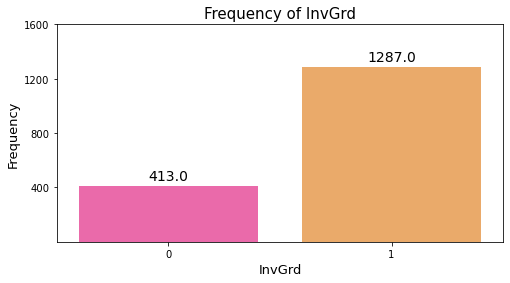

In [3]:
df = MLF_GP1.copy()    
# bar plot of multiRating
value_counts = df['InvGrd'].value_counts()
class_counts = pd.DataFrame({'Class': list(value_counts.index), 'value_count': value_counts})

plt.figure(figsize = (8,4))
g = sns.barplot(x = 'Class', y = 'value_count', data = class_counts, capsize = 0.3, palette = 'spring')
g.set_title("Frequency of InvGrd", fontsize = 15)
g.set_xlabel("InvGrd", fontsize = 13)
g.set_ylabel("Frequency", fontsize = 13)
g.set_yticks([400, 800, 1200, 1600])
for p in g.patches:
    g.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha = 'center', va = 'center', xytext=(0, 10), 
                textcoords='offset points', fontsize=14, color='black')

In [4]:
# Store the features in dataframe X
X = MLF_GP1[MLF_GP1.columns.values[:-2]]

# Standardize the features
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns = X.columns.values)
X_std.shape

(1700, 26)

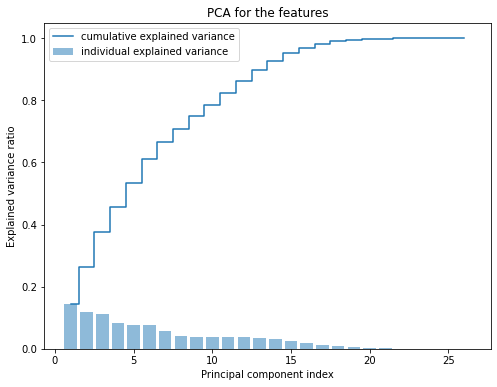

In [5]:
plt.figure(figsize = (8,6))
cov_mat = np.cov(X_std.values.T)
eigen_vals, eigen_vecs = la.eig(cov_mat)
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
            sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,27), var_exp, alpha=0.5, align='center',
         label='individual explained variance')
plt.step(range(1,27), cum_var_exp, where='mid',
        label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("PCA for the features")
plt.legend(loc='best')
plt.show()

## Binary Classification

In [6]:
# split in a stratified fashion
X_train, X_test, y_train, y_test = train_test_split(X.copy(), MLF_GP1['InvGrd'], test_size = 0.25, 
                                                    stratify = MLF_GP1['InvGrd'], random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1275, 26), (425, 26), (1275,), (425,))

In [7]:
scalerX = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train), columns = X.columns.values) 
X_test = pd.DataFrame(scalerX.transform(X_test), columns = X.columns.values)
pca = PCA(n_components = 15)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [8]:
# fit four basic classifier models
basic_classifier = ['logreg', 'Knn', 'decision tree', 'SVC']
estimator = [LogisticRegression(random_state = 123),
             KNeighborsClassifier(),
             DecisionTreeClassifier(random_state = 123),
             SVC(random_state = 123)]
for i in range(4):
    cv_score = cross_val_score(estimator[i], X_train, y_train, cv = 5)
    print('The accuracy score of 5-fold cross validation for {} is {} +/- {}'.format(basic_classifier[i],
                                                                                   np.round(np.mean(cv_score), 3),
                                                                                   np.round(np.std(cv_score), 3)))
    clf = estimator[i]
    clf.fit(X_train, y_train)
    print('The test accuracy score for {} is {}'.format(basic_classifier[i],
                                                         np.round(clf.score(X_test, y_test), 3)))
    print('----------------------------------------------------------------------')   

The accuracy score of 5-fold cross validation for logreg is 0.765 +/- 0.006
The test accuracy score for logreg is 0.751
----------------------------------------------------------------------
The accuracy score of 5-fold cross validation for Knn is 0.756 +/- 0.018
The test accuracy score for Knn is 0.769
----------------------------------------------------------------------
The accuracy score of 5-fold cross validation for decision tree is 0.74 +/- 0.025
The test accuracy score for decision tree is 0.715
----------------------------------------------------------------------
The accuracy score of 5-fold cross validation for SVC is 0.769 +/- 0.008
The test accuracy score for SVC is 0.762
----------------------------------------------------------------------


<font color=blue>Clearly, the Support Vector classifier has the best porformances since it has the highest cv training socre as well as the highest test score.</font>

<font color=blue>Then, we can narrow the range of the depth of the tree.</font>

### Support vector Classfier

In [9]:
# Hyperparameters tuning for a single decision tree
svc = SVC(random_state = 123)
regularization = [0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10]
kernel_type = ['linear', 'poly', 'rbf']
class_weight = ['balanced', None]

# define grid search
grid = dict(C = regularization, kernel = kernel_type, class_weight = class_weight)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
grid_search = GridSearchCV(estimator = svc, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = skf, 
                           scoring = 'accuracy', 
                           error_score = 0)
svc_cv = grid_search.fit(X_train, y_train)

In [10]:
svc_index = np.argmax(svc_cv.cv_results_['mean_test_score'])
scv_mean_train = np.round(svc_cv.best_score_, 3)
svc_std_train = np.round(svc_cv.cv_results_['std_test_score'][svc_index], 3)
svc_score = str(scv_mean_train) + ' +/- ' + str(svc_std_train)
print('The accuracy score of 5-fold cross validation is ' + svc_score)

The accuracy score of 5-fold cross validation is 0.791 +/- 0.031


In [11]:
print('The best parameters using cv is {}'.format(svc_cv.best_params_))

The best parameters using cv is {'C': 10, 'class_weight': None, 'kernel': 'rbf'}


In [12]:
svc = svc_cv.best_estimator_

svc_test = np.round(svc.score(X_test, y_test), 3)
print('The test accuracy score is',svc_test)

The test accuracy score is 0.779


### Random Forest Classfier

In [13]:
single_tree = DecisionTreeClassifier(random_state = 123).fit(X_train, y_train)
print("The max depth for a single decision tree is", single_tree.max_features_)

The max depth for a single decision tree is 15


In [14]:
# Hyperparameters tuning for a single decision tree
dt = DecisionTreeClassifier(random_state = 123)
depth = np.arange(2, 15, 1)

# define grid search
grid = dict(max_depth = depth)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
grid_search = GridSearchCV(estimator = dt, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = skf, 
                           scoring = 'accuracy', 
                           error_score = 0)
dt_cv = grid_search.fit(X_train, y_train)

In [15]:
print('The best parameters using cv is {}'.format(dt_cv.best_params_))

The best parameters using cv is {'max_depth': 3}


In [16]:
# Hyperparameters tuning for RF
rf = RandomForestClassifier(random_state = 123)
ne = [100, 300, 500]
depth = np.arange(3, 6, 1)
split = [2, 3, 4]
leaf = [1, 3, 5]
feature = ["auto", "log2", 'None']
class_weight = ['balanced', None]

# define grid search
grid = dict(n_estimators = ne, max_depth = depth, min_samples_split = split, 
            min_samples_leaf = leaf, max_features = feature, class_weight = class_weight)

grid_search = GridSearchCV(estimator = rf, 
                           param_grid = grid, 
                           n_jobs = -1, 
                           cv = skf, 
                           scoring = 'accuracy', 
                           error_score = 0)
rf_cv = grid_search.fit(X_train, y_train)

In [17]:
rf_index = np.argmax(rf_cv.cv_results_['mean_test_score'])
rf_mean_train = np.round(rf_cv.best_score_, 3)
rf_std_train = np.round(rf_cv.cv_results_['std_test_score'][rf_index], 3)
rf_score = str(rf_mean_train) + ' +/- ' + str(rf_std_train)
print('The accuracy score of 5-fold cross validation is ' + rf_score)

The accuracy score of 5-fold cross validation is 0.792 +/- 0.014


In [18]:
print('The best parameters using cv is {}'.format(dt_cv.best_params_))

The best parameters using cv is {'max_depth': 3}


In [19]:
rf = rf_cv.best_estimator_

rf_test = np.round(rf.score(X_test, y_test), 3)
print('The test accuracy score is',rf_test)

The test accuracy score is 0.788


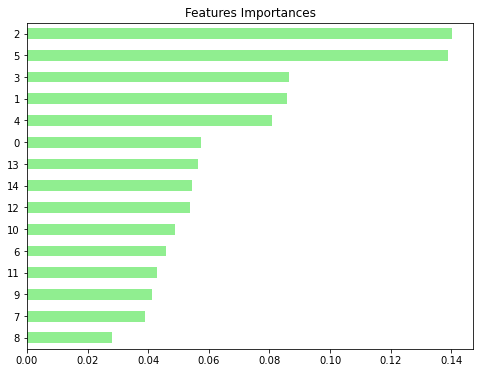

In [20]:
plt.figure(figsize = (8,6))

# Create a pd.Series of features importances
importances = pd.Series(data = rf.feature_importances_,
                        index = np.arange(0,15))

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind = 'barh', color = 'lightgreen')
plt.title('Features Importances')
plt.show()

### ANN

In [21]:
np.random.seed(123)
tf.random.set_seed(123)

In [22]:
X_train_new = X_train.astype('float32')
X_test_new = X_test.astype('float32')
y_train_new = to_categorical(y_train, 2)
y_test_new = to_categorical(y_test, 2)

In [23]:
def build_model(hp):
    model = models.Sequential()
    # Input layer
    model.add(
        layers.Dense(
            units = 15,
            activation = "relu", input_shape = (X_train_new.shape[1],)
        )
    )
    # First hidden layer
    model.add(
        layers.Dense(
            units = hp.Int("num of neurons in the hidden layer", 
                           min_value = 2, max_value = 26, step = 2, default = 26),
            activation = "relu",
        )
    )
    # Output layer
    model.add(layers.Dense(2, activation = "softmax"))
    
    model.compile(
        optimizer = keras.optimizers.Adam(
            hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])
        ),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"],
    )
    return model

In [24]:
tuner = RandomSearch(
    build_model,
    objective = "val_accuracy",
    max_trials = 5,
    seed = 123,
    overwrite = True,
    directory = "/Users/gaojinglun/Desktop/Coursework/IE517/Final Project"
)
tuner.search(X_train_new, y_train_new, epochs = 5, validation_split = 0.25)

Trial 5 Complete [00h 00m 00s]
val_accuracy: 0.7272727489471436

Best val_accuracy So Far: 0.739811897277832
Total elapsed time: 00h 00m 03s
INFO:tensorflow:Oracle triggered exit


In [25]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num of neurons in the hidden layer (Int)
{'default': 26, 'conditions': [], 'min_value': 2, 'max_value': 26, 'step': 2, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [26]:
# tuner.results_summary()

In [27]:
best_paras = tuner.get_best_hyperparameters(num_trials = 1)[0]
ANN = build_model(best_paras)
ANN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 64        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = ANN.fit(X_train_new, y_train_new, epochs = 5, validation_split = 0.25)

Epoch 1/5
30/30 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.7312 - val_loss: 0.6110 - val_accuracy: 0.7241
Epoch 2/5
30/30 [==============================] - 0s 1ms/step - loss: 0.5182 - accuracy: 0.7730 - val_loss: 0.6135 - val_accuracy: 0.7273
Epoch 3/5
30/30 [==============================] - 0s 1ms/step - loss: 0.4846 - accuracy: 0.7793 - val_loss: 0.6042 - val_accuracy: 0.7241
Epoch 4/5
30/30 [==============================] - 0s 1ms/step - loss: 0.4726 - accuracy: 0.7824 - val_loss: 0.6085 - val_accuracy: 0.7367
Epoch 5/5
30/30 [==============================] - 0s 1ms/step - loss: 0.4653 - accuracy: 0.7845 - val_loss: 0.6248 - val_accuracy: 0.7367


In [29]:
ann_mean_train = np.round(np.mean(history.history['val_accuracy']), 3)
ann_std_train = np.round(np.std(history.history['val_accuracy']), 3)
ann_score = str(ann_mean_train) + ' +/- ' + str(ann_std_train)
print('The accuracy score of 5 epochs validation is ' + ann_score)

The accuracy score of 5 epochs validation is 0.73 +/- 0.006


In [30]:
_, ann_test = ANN.evaluate(X_test_new, y_test_new)
ann_test = np.round(ann_test, 3)
print("The accuracy score for Neural Network is", ann_test)

14/14 [==============================] - 0s 928us/step - loss: 0.6721 - accuracy: 0.7412
The accuracy score for Neural Network is 0.741


## Results

<Figure size 1080x720 with 0 Axes>

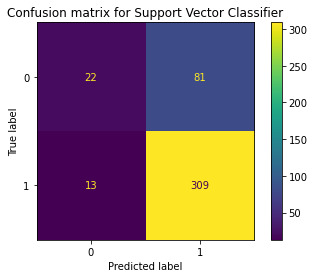

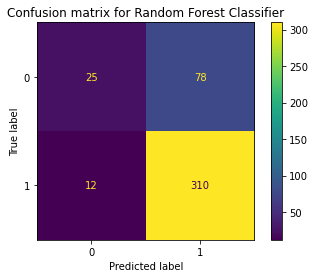

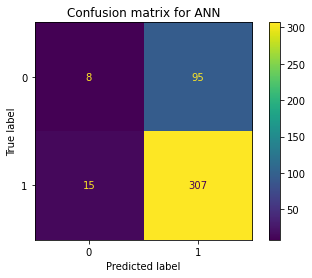

In [31]:
fig = plt.figure(figsize = (15,10))

ConfusionMatrixDisplay(confusion_matrix(y_test, svc.predict(X_test))).plot()
plt.title("Confusion matrix for Support Vector Classifier")
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_test, rf.predict(X_test)), 
                       display_labels = rf.classes_).plot()
plt.title("Confusion matrix for Random Forest Classifier")
plt.show()


pred = np.argmax(ANN.predict(X_test), axis = 1)
ConfusionMatrixDisplay(confusion_matrix(y_test, pred), 
                       display_labels = rf.classes_).plot()
plt.title("Confusion matrix for ANN")
plt.show()

In [32]:
Models = ['Support Vector', 'Random Forest', 'ANN']
train_acc = [svc_score, rf_score, ann_score]
test_acc = [svc_test, rf_test, ann_test]

table = pd.DataFrame(np.column_stack((Models, train_acc, test_acc)), 
                      columns = ['Modle Name', 'Train 5-fold CV / 5 epochs Accuracy', 'Test Accuracy'])
print(tabulate(table, headers = 'keys', showindex = False, tablefmt = "github"))

| Modle Name     | Train 5-fold CV / 5 epochs Accuracy   |   Test Accuracy |
|----------------|---------------------------------------|-----------------|
| Support Vector | 0.791 +/- 0.031                       |           0.779 |
| Random Forest  | 0.792 +/- 0.014                       |           0.788 |
| ANN            | 0.73 +/- 0.006                        |           0.741 |
